In [1]:
from mountaincar_env import MountainCarEnv
from collections import defaultdict
import numpy as np
from amalearn.agent import AgentBase
from gym import spaces
import matplotlib.pyplot as plt

In [2]:
basehash = hash

class IHT:
    
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0:
                print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):

    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [3]:
class MountainCarTileCoder:
    def __init__(self, iht_size, num_tilings, num_tiles):
        
        self.iht_size = iht_size
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity, action, env):
        
        max_pos, min_pos = env.max_position, env.min_position
        max_v, min_v = env.max_speed, -1*env.max_speed
        scaled_pos = (self.num_tiles*position) / (max_pos-min_pos)
        scaled_velocity = (self.num_tiles*velocity) / (max_v-min_v)
        active_tiles = tiles(self.iht, self.num_tilings, [scaled_pos, scaled_velocity], action)
        
        return np.array(active_tiles) / self.iht_size

In [4]:
class Agent(AgentBase):
    
    def __init__(self, id, environment, discount, alpha, epsilon, actions, state_coder, episodes=1000):
        
        self.actions = actions
        self.env = environment
        self.discount = discount
        self.alpha = alpha
        self.epsilon = epsilon
        self.episodes = episodes
        
        self.state_coder = state_coder
        self.theta = np.zeros(self.state_coder.num_tilings)
        self.q_values = defaultdict(int)
        
        super(Agent, self).__init__(id, environment)
        
    def update_q(self, state_action_coded):
        
        self.q_values[tuple(state_action_coded.tolist())] = np.matmul(self.theta, state_action_coded)
                    
    def sarsa(self):
        
        steps = []
        
        for episode in range(self.episodes):
            
            self.env.reset()
            step_counter = 0
            
            s = self.env.state
            a = self.select_action(s)
            s_coded = self.state_coder.get_tiles(s[0], s[1], [a], self.env)
            print(f'episode: {episode}')
            while True:
                
                step_counter += 1
                next_s, reward, done, _ = self.env.step(a)
                if done:
                    self.theta += self.alpha*(reward - self.q_values[tuple(s_coded.tolist())])*s_coded
                    break
                next_a = self.select_action(next_s)
                next_s_coded = self.state_coder.get_tiles(next_s[0], next_s[1], [next_a], self.env)
                G = reward + self.discount*self.q_values[tuple(next_s_coded.tolist())]
                self.theta += self.alpha*(G - self.q_values[tuple(s_coded.tolist())])*s_coded
                
                s, s_coded, a = next_s, next_s_coded, next_a
                self.update_q(s_coded)
#                 self.env.render()
#                 if (episode+1)%10 == 0:
            self.epsilon *= 0.99
            print(step_counter)
            steps.append(step_counter)
            
        return steps
                
    def select_action(self, s):
        
        q_values = np.array([self.q_values[tuple(self.state_coder.get_tiles(s[0], s[1], [a], self.env).tolist())] for a in self.actions])
        argmax = np.argmax(q_values)
        prob = [self.epsilon/len(self.actions) if a != argmax else 1-self.epsilon+self.epsilon/len(self.actions) for a in self.actions]
        action = np.random.choice(self.actions, p=prob)
        
        return int(action)
    
    def reset(self):
        
        self.theta = [np.zeros(self.state_coder.num_tilings) for a in self.actions]

In [5]:
env = MountainCarEnv()

state_coder = MountainCarTileCoder(4096, 2, 16)
agent = Agent('1', env, 0.9, 0.5/2, 0.5, [0, 1, 2], state_coder, 100)

steps_1 = agent.sarsa()

episode: 0
188131
episode: 1
50064
episode: 2
11560
episode: 3
540199
episode: 4
203005
episode: 5
265678
episode: 6
185966
episode: 7
13339
episode: 8
243256
episode: 9
17539
episode: 10
4707
episode: 11
4039
episode: 12
64676
episode: 13
47767
episode: 14
128549
episode: 15
99178
episode: 16
2820
episode: 17
33953
episode: 18
76918
episode: 19
128355
episode: 20
869559
episode: 21
148346
episode: 22
27408
episode: 23
64867
episode: 24
72025
episode: 25
1665
episode: 26
150548
episode: 27
68422
episode: 28
5038
episode: 29
241458
episode: 30
46592
episode: 31
332857
episode: 32
53221
episode: 33
332718
episode: 34
94225
episode: 35
440597
episode: 36
27955
episode: 37
69957
episode: 38
127953
episode: 39
14936
episode: 40
7123
episode: 41
20109
episode: 42
38191
episode: 43
738
episode: 44
29955
episode: 45
128482
episode: 46
29062
episode: 47
8696
episode: 48
342181
episode: 49
241543
episode: 50
28493
episode: 51
23028
episode: 52
12271
episode: 53
9838
episode: 54
122168
episode: 5

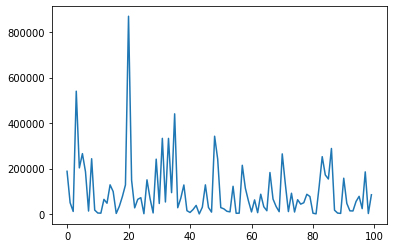

In [6]:
plt.plot(steps_1)

In [7]:
state_coder = MountainCarTileCoder(4096, 32, 4)
agent = Agent('1', env, 0.9, 0.5/32, 0.5, [0, 1, 2], state_coder, 100)

steps_2 = agent.sarsa()

episode: 0
610470
episode: 1
44188
episode: 2
83002
episode: 3
46629
episode: 4
33456
episode: 5
35032
episode: 6
20412
episode: 7
12281
episode: 8
129841
episode: 9
162896
episode: 10
24753
episode: 11
77776
episode: 12
73816
episode: 13
23121
episode: 14
18018
episode: 15
53468
episode: 16
8544
episode: 17
3199
episode: 18
59838
episode: 19
118725
episode: 20
25188
episode: 21
14587
episode: 22
1555
episode: 23
20306
episode: 24
4891
episode: 25
49231
episode: 26
69921
episode: 27
82523
episode: 28
3046
episode: 29
20027
episode: 30
57050
episode: 31
35527
episode: 32
11930
episode: 33
9403
episode: 34
39138
episode: 35
1813
episode: 36
11555
episode: 37
55024
episode: 38
217882
episode: 39
6058
episode: 40
8795
episode: 41
123165
episode: 42
7770
episode: 43
160580
episode: 44
121343
episode: 45
39265
episode: 46
94670
episode: 47
37105
episode: 48
15134
episode: 49
15972
episode: 50
69982
episode: 51
27351
episode: 52
11934
episode: 53
32004
episode: 54
72082
episode: 55
110888
epi

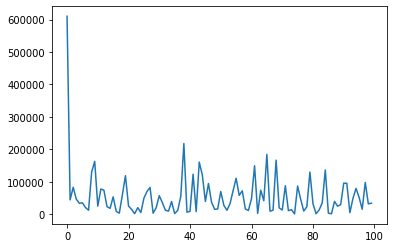

In [8]:
plt.plot(steps_2)

In [9]:
state_coder = MountainCarTileCoder(4096, 8, 8)
agent = Agent('1', env, 0.9, 0.5/8, 0.5, [0, 1, 2], state_coder, 100)

steps_3 = agent.sarsa()

episode: 0
502006
episode: 1
56208
episode: 2
13472
episode: 3
38712
episode: 4
64368
episode: 5
4076
episode: 6
27200
episode: 7
131180
episode: 8
29366
episode: 9
19663
episode: 10
125826
episode: 11
6956
episode: 12
84521
episode: 13
45663
episode: 14
6385
episode: 15
28824
episode: 16
54852
episode: 17
47623
episode: 18
11618
episode: 19
35814
episode: 20
10685
episode: 21
24456
episode: 22
328719
episode: 23
6100
episode: 24
71524
episode: 25
44639
episode: 26
74947
episode: 27
29281
episode: 28
193926
episode: 29
22342
episode: 30
56574
episode: 31
229895
episode: 32
17645
episode: 33
531583
episode: 34
151400
episode: 35
49567
episode: 36
56998
episode: 37
52211
episode: 38
6396
episode: 39
5419
episode: 40
16901
episode: 41
10519
episode: 42
54036
episode: 43
20389
episode: 44
14702
episode: 45
116701
episode: 46
127816
episode: 47
10223
episode: 48
41201
episode: 49
131235
episode: 50
30505
episode: 51
95803
episode: 52
1533
episode: 53
127645
episode: 54
7432
episode: 55
1605

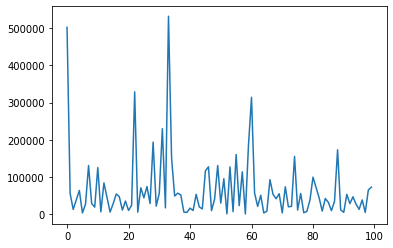

In [10]:
plt.plot(steps_3)

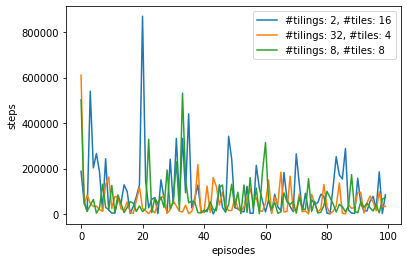

In [14]:
plt.plot(steps_1, label='#tilings: 2, #tiles: 16')
plt.plot(steps_2, label='#tilings: 32, #tiles: 4')
plt.plot(steps_3, label='#tilings: 8, #tiles: 8')
plt.legend()
plt.xlabel('episodes')
plt.ylabel('steps')
plt.show()

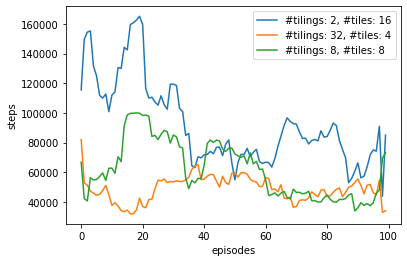

In [17]:
window_size = 20
plt.plot([np.mean(steps_1[i:i+window_size]) for i in range(len(steps_1))], label='#tilings: 2, #tiles: 16')
plt.plot([np.mean(steps_2[i:i+window_size]) for i in range(len(steps_2))], label='#tilings: 32, #tiles: 4')
plt.plot([np.mean(steps_3[i:i+window_size]) for i in range(len(steps_3))], label='#tilings: 8, #tiles: 8')
plt.legend()
plt.xlabel('episodes')
plt.ylabel('steps')
plt.show()